# Minimal viable product - Linear model, total daily production

This is a first attempt to get an idea for the prediction of the solar panel output.

The data for the solar panel production is aggregated by the sum of day.


In [1]:
import datetime
import numpy as np
import pandas as pd
import requests
import re
import json
import os
from dateutil import tz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Load data - production, aggregate by day

In [44]:
# production data
path_to_files = './data/production/'
data_prod = pd.read_csv(f'{path_to_files}/solar_production.data', index_col=0) # make it .data so that it is not csv
data_prod['Time'] = pd.to_datetime(data_prod['Time'])
data_prod = data_prod.set_index('Time')

# find day
data_prod['Day'] = data_prod.index.map(lambda x: f'{x.year}-{x.month}-{x.day}')
data_prod = data_prod.groupby('Day')['Production'].agg(['sum'])
data_prod.columns = ['Production_sum']

# order ascending
data_prod =  data_prod.reset_index()
data_prod['Day'] = pd.to_datetime(data_prod['Day'])
data_prod = data_prod.sort_values(by=['Day'])
data_prod = data_prod.set_index('Day')

# first and last day
print(data_prod.iloc[0], data_prod.iloc[-1])
data_prod.head()

Production_sum    11629.3334
Name: 2017-10-12 00:00:00, dtype: float64 Production_sum    106414.9997
Name: 2019-06-27 00:00:00, dtype: float64


,Production_sum
Day,
2017-10-12,11629.3334
2017-10-13,118196.0001
2017-10-14,114615.3339
2017-10-15,113638.9996
2017-10-16,109484.3342


# Load data - sun position, maximum and minimum per day

In [53]:
save_path = "./data/pysolar/"
data_solar = pd.read_csv(f'{save_path}/sun_data.csv', index_col=0)
data_solar['date'] = pd.to_datetime(data_solar['date'])
data_solar = data_solar.set_index('date')

# order ascending
data_solar['Day'] = data_solar.index.map(lambda x: f'{x.year}-{x.month}-{x.day}')
data_solar['Day'] = pd.to_datetime(data_solar['Day'])
data_solar = data_solar.sort_index()

# find min and max
data_solar = data_solar.groupby('Day')['altitude', 'azimuth', 'clear_sky_irradiation'].agg(['min', 'max'])
# data_solar.columns = ['Production_sum']
data_solar.columns = ['_'.join(col) for col in data_solar.columns]
data_solar = data_solar.drop('clear_sky_irradiation_min', axis=1)

# select the correct dates from 2017-10-12 until 2019-06-27
data_solar = data_solar.loc['2017-10-12':'2019-06-27',:]

print(data_solar.head())
print(data_solar.tail())

            altitude_min  altitude_max  azimuth_min  azimuth_max  \
Day                                                                
2017-10-12    -49.374586     34.474052    19.567055   357.069346   
2017-10-13    -49.751088     34.102303    19.783644   357.143860   
2017-10-14    -50.125721     33.732240    19.999179   357.215996   
2017-10-15    -50.498382     33.363977    20.213501   357.285596   
2017-10-16    -50.868963     32.997630    20.426448   357.352506   

            clear_sky_irradiation_max  
Day                                    
2017-10-12                 864.755684  
2017-10-13                 864.100214  
2017-10-14                 863.409922  
2017-10-15                 862.684519  
2017-10-16                 861.923764  
            altitude_min  altitude_max  azimuth_min  azimuth_max  \
Day                                                                
2019-06-23    -18.418040     65.032641     8.880509   354.394511   
2019-06-24    -18.426877     65.009055 

# Load data - weather data

Treat each column separately

### Functions to clean the data

In [70]:
def clean_precipitation_columns(data):
    """
    Cleans the precipitation columns in the dataset, these are: 
    - precipAccumulation 
        - The amount of snowfall accumulation expected to occur, in inches. 
        (If no snowfall is expected, this property will not be defined.)   
    - precipIntensity optional
        - The intensity (in inches of liquid water per hour) of precipitation occurring at the given time. 
        This value is conditional on probability (that is, assuming any precipitation occurs at all).
    - precipProbability optional
        - The probability of precipitation occurring, between 0 and 1, inclusive.
    - precipType optional
        - The type of precipitation occurring at the given time. If defined, this property will have one of the following values: 
        "rain", "snow", or "sleet" (which refers to each of freezing rain, ice pellets, and “wintery mix”). 
        (If precipIntensity is zero, then this property will not be defined. Additionally, due to the lack of data in our sources, 
        historical precipType information is usually estimated, rather than observed.)
        
    precipAccumulation: 
        if there is no snow, there is no accumulation anyways. We will fill the values in these rows for that column with 0.
    precipType, precipIntensity, and precipProbability:
        Must be nonzero if precipIntensity is nonzero. Else it will be set to 0. precipProbability will be set to 0 for nonzero
  
    returns: cleaned dataframe
    """
    rows = data[data['precipAccumulation'].isnull()].index
    data.loc[rows,'precipAccumulation'] = 0
    assert len(data[data['precipAccumulation'].isnull()]) == 0
    
    rows = data[(data['precipIntensity'] > 0) & (data['precipType'] == np.nan)]
    assert len(rows) == 0

    rows = data[data['precipIntensity'].isnull()].index
    data.loc[rows,'precipIntensity'] = 0
    rows = data[data['precipType'].isnull()].index
    data.loc[rows,'precipType'] = 'None'
    rows = data[data['precipProbability'].isnull()].index
    data.loc[rows,'precipProbability'] = 0
    assert len(data[data['precipIntensity'].isnull()]) == 0
    assert len(data[data['precipType'].isnull()]) == 0
    assert len(data[data['precipProbability'].isnull()]) == 0
    
    return data


def clean_continuous_features(data, order=3, do_plot=False):
    """
    Cleans the columns: apparentTemperature, cloudCover, humidity, pressure, temperature, uvIndex, visibility, windSpeed
    
    Fits an interpolation function polynomial with order of order to the data.
    If do_plot is True, it will generate plots
    """
    cols = ['apparentTemperature', 'cloudCover', 'humidity', 'pressure', 'temperature', 'uvIndex', 'visibility', 'windSpeed']
    for col in cols:
        max_t = data[col].max()
        min_t = data[col].min()
        if do_plot:
            print(f'Treating column {col}, plotting 2018-01 until 2018-08') 
            print(f'Max and min values for this column are: {max_t} {min_t}')
            s1 = data.loc['2018-01':'2018-08'][col]
            plt.figure(figsize=(10,5))
            plt.plot(s1.values)
            plt.title('Before interpolation')
            plt.ylabel(col)

            plt.show()

        # interpolate
        data[col] = data[col].interpolate(method='polynomial', order=order)
        # prevent negative values for certain columns
        if min_t >= 0:
    #         print(col)
            data[col] = data[col].clip(lower=0,upper=None)

        # prevent extreme values by ceiling them to the maximum
        data[col][data[col]>max_t] = max_t
        if do_plot:
            s2=data.loc['2018-01':'2018-08'][col]
            plt.figure(figsize=(10,5))
        #     print(s)
            plt.plot(s2.values)
            plt.title('After interpolation')

            plt.ylabel(col)
            plt.show()
        
    return data


### Functions to aggregate the data 

In [88]:
def agg_by_sum(data, columns, agg_by, agg_over='Day'):
    """
    Takes a dataframe and list of columns which should be aggregated. agg_by is the aggregation function, i.e. sum.
    The agg_over string is the column over which to aggregate. 
    Aggregates by the sum of the day, returns a dataframe.
    """
    data = data.groupby(agg_over)[columns].agg([agg_by])
    data.columns = ['_'.join(col) for col in data.columns]
    
    return data


In [106]:
# import the data
path_to_jsons = './data/DarkSkyAPI/'
data_w = pd.read_csv(f'{path_to_jsons}/darkSkyData_cleaned_extracted.csv', index_col = 0)
data_w.index = pd.to_datetime(data_w.index, format='%Y-%m-%d %H:%M:%S')

# clean precipitation data
data_w = clean_precipitation_columns(data_w)

# clean continuous columns
data_w = clean_continuous_features(data_w, order=3, do_plot=False)

# apparentTemperature and temperature: take maximum
# print(data_w.isna().sum())
data_w['Day'] = data_w.index.map(lambda x: f'{x.year}-{x.month}-{x.day}')
data_w['Day'] = pd.to_datetime(data_w['Day'])

# aggregation
# sum
cols_sum = ['precipAccumulation', 'precipIntensity']

# min
cols_min = ['apparentTemperature', 'temperature', 'pressure', 'windSpeed', 'cloudCover','humidity', 'uvIndex', 'visibility']

# max
cols_max = ['apparentTemperature', 'temperature', 'pressure', 'windSpeed', 'cloudCover','humidity', 'uvIndex','visibility']

# mean
cols_mean = ['apparentTemperature', 'temperature','pressure', 'windSpeed', 'cloudCover','humidity', 'uvIndex','visibility']

# median
cols_median = ['apparentTemperature', 'temperature', 'pressure', 'windSpeed', 'cloudCover','humidity', 'uvIndex','visibility']


df_sum = agg_by_sum(data_w, cols_sum, 'sum', agg_over='Day')
df_min = agg_by_sum(data_w, cols_min, 'min', agg_over='Day')
df_max = agg_by_sum(data_w, cols_max, 'max', agg_over='Day')
df_mean = agg_by_sum(data_w, cols_mean, 'mean', agg_over='Day')
df_median = agg_by_sum(data_w, cols_median, 'median', agg_over='Day')



data_w = pd.concat([df_sum, df_min, df_max, df_mean, df_median], axis=1)

# select the correct dates from 2017-10-12 until 2019-06-27
data_w = data_w.loc['2017-10-12':'2019-06-27',:]

data_w.head()

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,precipAccumulation_sum,precipIntensity_sum,apparentTemperature_min,temperature_min,pressure_min,windSpeed_min,cloudCover_min,humidity_min,uvIndex_min,visibility_min,...,uvIndex_mean,visibility_mean,apparentTemperature_median,temperature_median,pressure_median,windSpeed_median,cloudCover_median,humidity_median,uvIndex_median,visibility_median
Day,,,,,,,,,,,,,,,,,,,,,
2017-10-12,0.0,0.0,9.65,9.65,1023.03,0.10,0.0,0.64,0.0,9.988,...,5.833333e-01,9.992000,13.595,13.595,1025.765,1.065,0.490000,0.780,0.0,9.992
2017-10-13,0.0,0.0,7.29,7.29,1025.96,0.04,0.0,0.57,0.0,5.884,...,0.000000e+00,9.822000,11.850,11.850,1028.900,0.215,0.300688,0.900,0.0,9.996
2017-10-14,0.0,0.0,7.70,7.70,1026.23,0.03,0.0,0.58,0.0,9.988,...,5.182744e-17,9.988000,11.965,11.965,1029.100,0.135,0.000000,0.885,0.0,9.988
2017-10-15,0.0,0.0,7.29,7.29,1024.80,0.02,0.0,0.45,0.0,3.795,...,0.000000e+00,9.522875,12.135,12.135,1028.910,0.175,0.000000,0.830,0.0,9.988
2017-10-16,0.0,0.0,8.09,8.09,1024.23,0.07,0.0,0.43,0.0,9.988,...,1.958611e-33,9.992333,12.475,12.475,1028.145,0.225,0.000000,0.765,0.0,9.996


# Prediction target

Prediction will be based if the next day produces more or less than the mean of the produced production, i.e. 

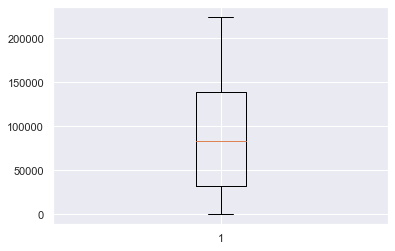

In [19]:
plt.boxplot(data_prod['Production_sum'])
plt.show()

In [104]:
target = data_prod['Production_sum'].mean() # in Watt
print(target) # mean in Watt
data_prod['Y'] = data_prod['Production_sum'].map(lambda x: 1 if x>target else 0)
data_prod.sample(10)

90643.95940977565


,Production_sum,Y
Day,,
2019-01-03,30668.6668,0
2018-07-14,186440.0002,1
2018-06-10,186000.3336,1
2019-01-13,2917.6666,0
2018-05-13,30166.3330,0
2019-06-09,83471.3333,0
2018-01-07,24347.6666,0
2018-06-05,132129.9992,1
2018-07-29,194691.6659,1


# Model

In [108]:
data_w.shape, data_prod.shape, data_solar.shape # all should have same length

((624, 34), (624, 2), (624, 5))

In [109]:
data = pd.concat([data_w, data_prod, data_solar], axis=1)

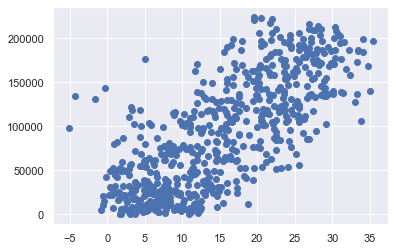

In [111]:
plt.scatter(data['temperature_max'], data['Production_sum'])
plt.show()

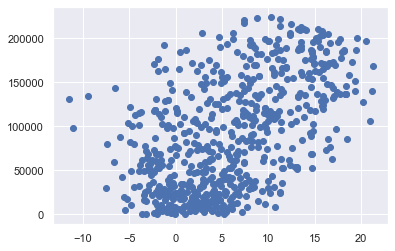

In [112]:
plt.scatter(data['temperature_min'], data['Production_sum'])
plt.show()

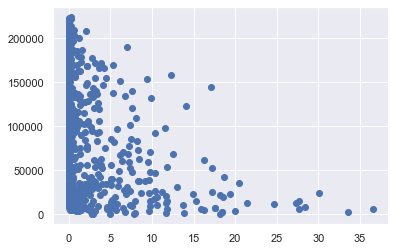

In [116]:
plt.scatter(data['precipIntensity_sum'], data['Production_sum'])
plt.show()